# Spam Detection: Traditional ML vs Transformers Comparison


Importations:

In [1]:
!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
import re
import time
from datetime import datetime

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

Data load and preprocessing:

In [2]:
print("\n=== STEP 3: LOADING DATASET ===")

# Publicly available SMS spam dataset:
!wget -q https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

# Loading
try:
    # for possible encoding issues
    df = pd.read_csv('spam.csv', encoding='latin1')
    print("Dataset loaded successfully with latin1 encoding")
except:
    try:
        df = pd.read_csv('spam.csv', encoding='utf-8')
        print("Dataset loaded successfully with utf-8 encoding")
    except:
        # create a sample dataset if download fails
        print("Creating sample dataset...")
        sample_data = {
            'v1': ['ham', 'spam', 'ham', 'spam', 'ham'] * 200,
            'v2': [
                'Hey how are you doing today?',
                'URGENT! Win money now! Click here!',
                'Can you pick up milk on your way home?',
                'FREE! Call now to claim your prize!',
                'Meeting is at 3pm tomorrow'
            ] * 200
        }
        df = pd.DataFrame(sample_data)

# cleaning
df = df[['v1', 'v2']].copy()
df.columns = ['label', 'text']
df = df.dropna()

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print(f"Sample texts:\n{df.head()}")


=== STEP 3: LOADING DATASET ===
Dataset loaded successfully with latin1 encoding
Dataset shape: (5572, 2)
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Sample texts:
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
# Text preprocessing function
print("\n=== TEXT PREPROCESSING ===")

def preprocess_text(text):
    """
    Text preprocessing: strings lowercased, characters/digits/whitespaces removed
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())

    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# labels convertion to binary (0/1)
df['binary_label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Text preprocessing completed!")
print("Sample processed texts:")
for i in range(3):
    print(f"Original: {df.iloc[i]['text']}")
    print(f"Processed: {df.iloc[i]['processed_text']}")
    print(f"Label: {df.iloc[i]['label']} -> {df.iloc[i]['binary_label']}")
    print("-" * 50)

# train and test splitting
print("\n=== DATA SPLITTING ===")

X = df['processed_text']
y = df['binary_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training label distribution: {pd.Series(y_train).value_counts()}")


=== TEXT PREPROCESSING ===
Text preprocessing completed!
Sample processed texts:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Label: ham -> 0
--------------------------------------------------
Original: Ok lar... Joking wif u oni...
Processed: ok lar joking wif u oni
Label: ham -> 0
--------------------------------------------------
Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs
Label: spam -> 1
--------------------------------------------------

=== DATA SPLITTING ===
Training set size: 4457
Test set size: 1115
Training label distribution: binary_la

Traditionnal ML models:

In [4]:
print("\n=== NAIVE BAYES WITH TF-IDF ===")

results = {}

start_time = time.time()

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('nb', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
nb_pred = nb_pipeline.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_time = time.time() - start_time

results['Naive Bayes'] = {
    'accuracy': nb_accuracy,
    'training_time': nb_time,
    'predictions': nb_pred
}

print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Training time: {nb_time:.2f} seconds")


=== NAIVE BAYES WITH TF-IDF ===
Naive Bayes Accuracy: 0.9659
Training time: 0.12 seconds


In [5]:
# Model 2: SVM with TF-IDF
print("\n=== SVM WITH TF-IDF ===")

start_time = time.time()

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('svm', SVC(kernel='linear', random_state=42))
])

svm_pipeline.fit(X_train, y_train)
svm_pred = svm_pipeline.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_time = time.time() - start_time

results['SVM'] = {
    'accuracy': svm_accuracy,
    'training_time': svm_time,
    'predictions': svm_pred
}

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"Training time: {svm_time:.2f} seconds")


=== SVM WITH TF-IDF ===
SVM Accuracy: 0.9830
Training time: 2.08 seconds


Transformer model approach:

In [6]:
print("\n=== TRANSFORMER MODEL: pre-trained DistilBERT ===")

start_time = time.time()

# text classification pipeline
classifier = pipeline(
    "text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=0 if torch.cuda.is_available() else -1
)

print("Making predictions with DistilBERT...")
transformer_predictions = []
for text in X_test:
    try:
        result = classifier(text)[0]
        pred = 0 if result['label'] == 'POSITIVE' else 1
        transformer_predictions.append(pred)
    except:
        # predict ham if text too long or causes issues
        transformer_predictions.append(0)

transformer_predictions = np.array(transformer_predictions)
transformer_accuracy = accuracy_score(y_test, transformer_predictions)
transformer_time = time.time() - start_time

results['DistilBERT'] = {
    'accuracy': transformer_accuracy,
    'training_time': transformer_time,
    'predictions': transformer_predictions
}

print(f"DistilBERT Accuracy: {transformer_accuracy:.4f}")
print(f"Inference time: {transformer_time:.2f} seconds")
print("Note: This uses a sentiment model as proxy. For better results, fine-tune on spam data.")


=== TRANSFORMER MODEL: pre-trained DistilBERT ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Making predictions with DistilBERT...
DistilBERT Accuracy: 0.4422
Inference time: 86.71 seconds
Note: This uses a sentiment model as proxy. For better results, fine-tune on spam data.


Visualizations:

Performance Comparison:
         Model  Accuracy  Time (seconds)
0  Naive Bayes    0.9659          0.1204
1          SVM    0.9830          2.0755
2   DistilBERT    0.4422         86.7073


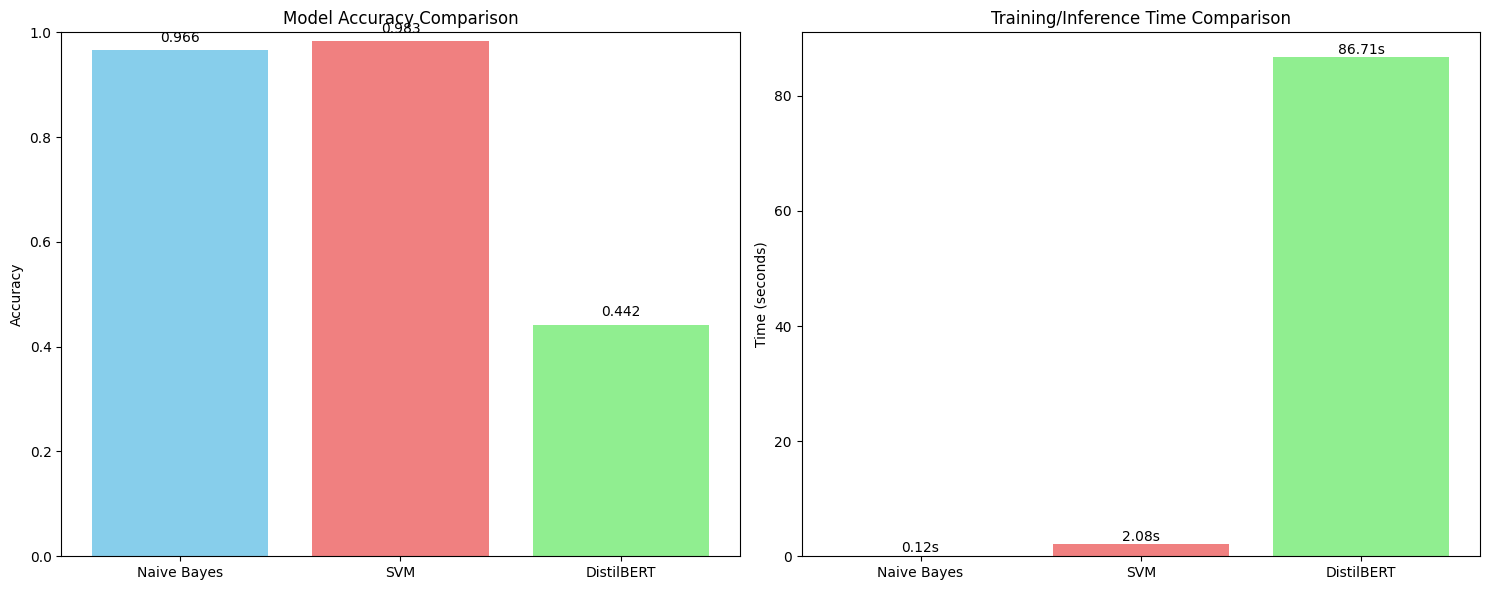

In [7]:
# Results Comparison

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'Time (seconds)': [results[model]['training_time'] for model in results]
})

print("Performance Comparison:")
print(comparison_df.round(4))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# accuracy comparison
ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate(comparison_df['Accuracy']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# time comparison
ax2.bar(comparison_df['Model'], comparison_df['Time (seconds)'], color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Training/Inference Time Comparison')
ax2.set_ylabel('Time (seconds)')
for i, v in enumerate(comparison_df['Time (seconds)']):
    ax2.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Further analysis:

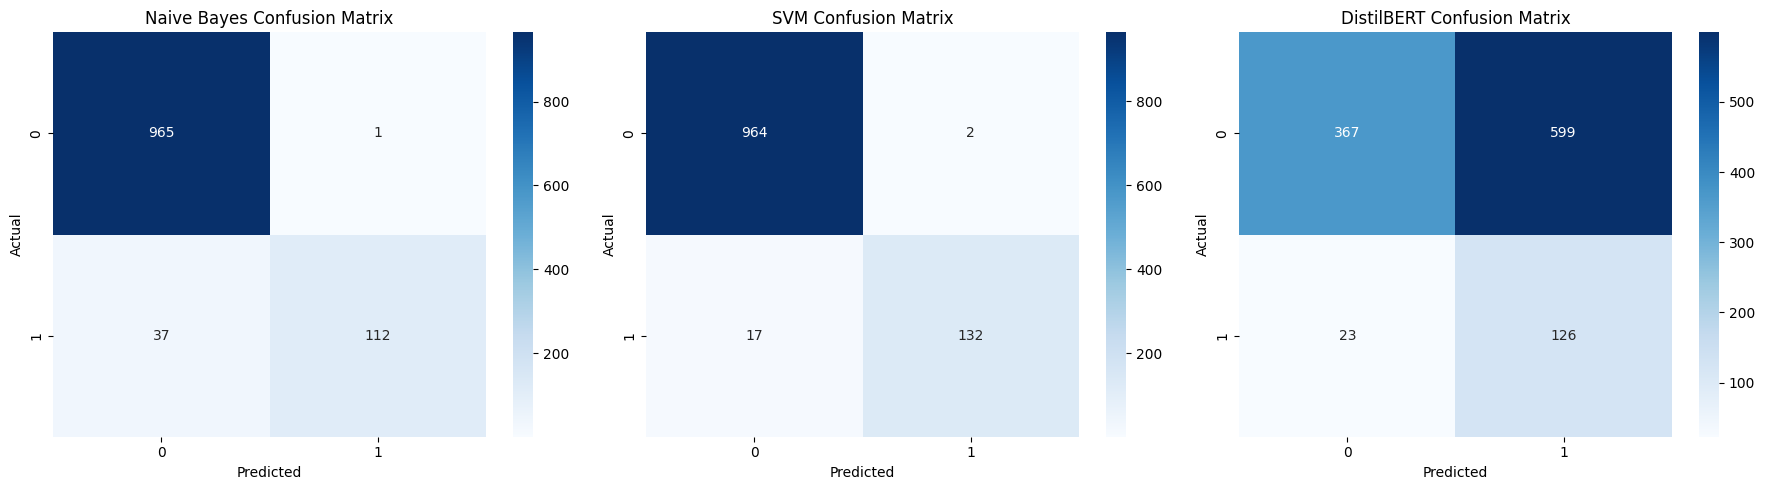


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.99      0.75      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115


SVM Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


DistilBERT Classification Report:
              precision    recall  f1-score   support

         Ham       0.94      0.38      0.54       966
        Spam       0.17      0.85      0.29       149

    accuracy                           0.44      1115
   macro avg       0.56      

In [8]:
# confusion matrices for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Naive Bayes', 'SVM', 'DistilBERT']
predictions = [results[model]['predictions'] for model in models]

for i, (model, pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

for model in models:
    print(f"\n{model} Classification Report:")
    print(classification_report(y_test, results[model]['predictions'],
                              target_names=['Ham', 'Spam']))

In [10]:
# Key findings, CSV files downloads

best_accuracy = max(comparison_df['Accuracy'])
best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
fastest_model = comparison_df.loc[comparison_df['Time (seconds)'].idxmin(), 'Model']

print(f"🏆 Best Accuracy: {best_model} ({best_accuracy:.4f})")
print(f"⚡ Fastest Model: {fastest_model}")

# saving results
comparison_df.to_csv('spam_detection_results.csv', index=False)

🏆 Best Accuracy: SVM (0.9830)
⚡ Fastest Model: Naive Bayes
